In [48]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
import matplotlib.font_manager as fm
from IPython.display import display, HTML
from tqdm import tqdm
from collections import Counter
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr, spearmanr, linregress, gaussian_kde



In [12]:

def initialize_notebook():
    """
        Functions to initialize plot settings for paper publication 
    """
    
    # Display settings for the Jupyter notebook
    display(HTML("<style>:root { --jp-notebook-max-width: 95% !important; }</style>"))
    # Add the font to the font manager
    #fm.fontManager.addfont('/projects/p30802/Cydney/Arial.ttf') #Path to Arial font 
    # Set the font globally
    #plt.rc('font', family='Arial')

    # Set default figure size and DPI
    plt.rcParams['figure.figsize'] = (1.7, 1.6)
    plt.rcParams['figure.dpi'] = 400

    # Set default grid settings
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color'] = '0.8'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = 0.3
    plt.rcParams['grid.alpha'] = 0.3

    # Set default tick parameters
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.major.width'] = 0.25
    plt.rcParams['ytick.major.width'] = 0.25
    plt.rcParams['xtick.major.size'] = 2  # This is the length
    plt.rcParams['ytick.major.size'] = 2  # This is the length
    plt.rcParams['xtick.major.pad'] = 2
    plt.rcParams['ytick.major.pad'] = 2

    # Set default spine width
    plt.rcParams['axes.linewidth'] = 0.25

    # Set default labels and title size
    plt.rcParams['axes.labelsize'] = 6
    plt.rcParams['axes.titlesize'] = 7
    plt.rcParams['axes.labelpad'] = 0.5

    # Set default legend settings
    plt.rcParams['legend.fontsize'] = 5
    plt.rcParams['legend.title_fontsize'] = 6

    # Automatically apply the function to remove spines whenever a figure is created
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False

initialize_notebook()

In [ ]:

def bootstrap_corr_slope(x, y, n_bootstrap=1000):
    """
        Bootstrap slope, intercept, Pearson's r, and Spearman's rank correlation by sampling the distribution with replacement 1000 times 

        Input
            arrays with the x and y values
        Output
            mean and 95% confidence interval for slope, intercept, Pearson's r, and Spearman's rank correlation
    """
    pearsons = []
    spearmans = []
    slopes = []
    intercepts = []
    
    rng = np.random.default_rng(seed=42)
    n = len(x)
    
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        x_sample = x[idx]
        y_sample = y[idx]
        
        # Correlations
        pearsons.append(pearsonr(x_sample, y_sample)[0])
        spearmans.append(spearmanr(x_sample, y_sample)[0])
        
        # Linear regression
        slope, intercept, _, _, _ = linregress(x_sample, y_sample)
        slopes.append(slope)
        intercepts.append(intercept)
        
        slope, intercept= np.polyfit(x_sample, y_sample,1)
        slopes.append(slope)
        intercepts.append(intercept)
    
    # Return 95% CI
    def ci(data):
        return np.percentile(data, [2.5, 97.5])

    return {
        'pearson': (np.mean(pearsons), ci(pearsons)),
        'spearman': (np.mean(spearmans), ci(spearmans)),
        'slope': (np.mean(slopes), ci(slopes)),
        'intercept': (np.mean(intercepts), ci(intercepts)),
    }
def format_ci(mean, ci):
    """
    Format the confidence interval to show up on plot as mean ± half 95% CI
    """
    half_range = (ci[1] - ci[0]) / 2
    return f"{mean:.2f} ± {half_range:.2f}"

In [56]:
def find_peak_dist(data):
    """
    Find the x value of the peak (mode) for a distribution

    Input 
         array of data for the distribution
    Output 
        peak_x: float value, x value for the mode of the distribution
        peak_y: float value, y value (KDE density) at the peak
    """
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    kde_values = kde(x)
    peak_x = x[np.argmax(kde_values)] 
    peak_y = np.max(kde_values)
    
    return peak_x, peak_y

In [57]:
#Datasets from the publication Global Analysis of Aggregation Determinants in Small Protein Domains can be downloaded from Zenodo : https://doi.org/10.5281/zenodo.17477631
meta1 = pd.read_csv("/Users/cydneymartell/Desktop/Datasets_for_publishing_v2/MS_Intensity_AggregationCalcs_Metagenomic_1.csv")
meta2 = pd.read_csv("/Users/cydneymartell/Desktop/Datasets_for_publishing_v2/MS_Intensity_AggregationCalcs_Metagenomic_2.csv")


## Centering the peak at 0 to remove "enrichment" effect

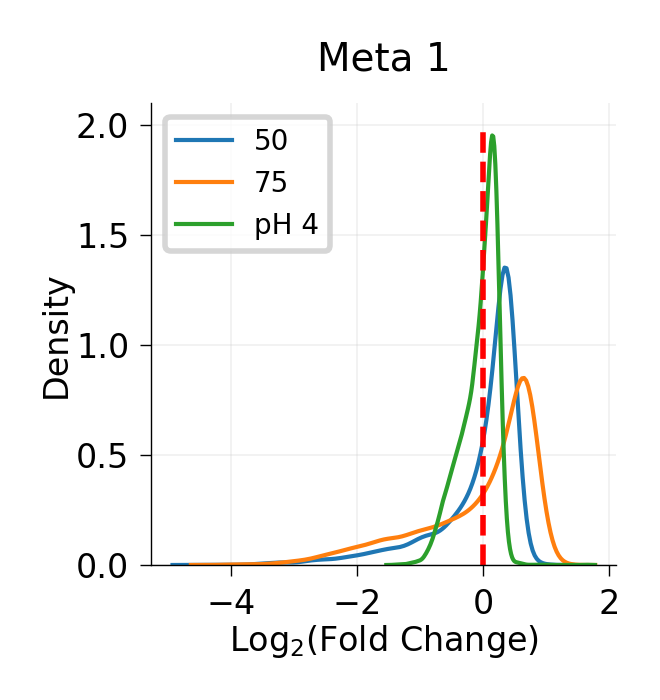

In [53]:
plt.figure(figsize = (1.5,1.5))
sns.kdeplot(meta1["log2_avg_norm_total_50_div_avg_norm_total_25_not_center_not_clip"], label = "50", linewidth=0.75)
sns.kdeplot(meta1["log2_avg_norm_total_75_div_avg_norm_total_25_not_center_not_clip"], label = "75" , linewidth=0.75)
sns.kdeplot(meta1["log2_avg_norm_total_4_div_avg_norm_total_7_not_center_not_clip"], label = "pH 4" , linewidth=0.75)
plt.xlabel(r'$\mathrm{Log}_{2}$(Fold Change)' ,fontsize = 6)
plt.legend()

plt.plot([0,0],[0,2], color = "red", linestyle = "--", linewidth = 1)
plt.title("Meta 1")
initialize_notebook()

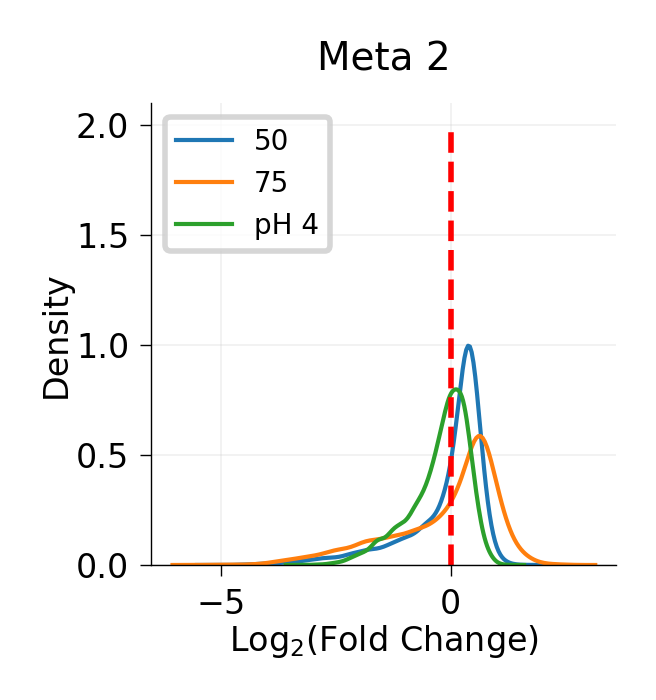

In [54]:
plt.figure(figsize = (1.5,1.5))

sns.kdeplot(meta2["log2_avg_norm_total_50_div_avg_norm_total_25_not_center_not_clip"], label = "50", linewidth=0.75)
sns.kdeplot(meta2["log2_avg_norm_total_75_div_avg_norm_total_25_not_center_not_clip"], label = "75" , linewidth=0.75)
sns.kdeplot(meta2["log2_avg_norm_total_4_div_avg_norm_total_7_not_center_not_clip"], label = "pH 4" , linewidth=0.75)
plt.xlabel(r'$\mathrm{Log}_{2}$(Fold Change)' ,fontsize = 6)
plt.legend()

plt.plot([0,0],[0,2], color = "red", linestyle = "--", linewidth = 1)
plt.title("Meta 2")
initialize_notebook()

In [61]:
#normalize data to peak at 0
vals_to_normalize = ["log2_avg_norm_total_50_div_avg_norm_total_25_not_center_not_clip", "log2_avg_norm_total_75_div_avg_norm_total_25_not_center_not_clip", "log2_avg_norm_total_4_div_avg_norm_total_7_not_center_not_clip"]
for i in vals_to_normalize:
    label = i[:-20]
    x_peak_m1, y_peak_m1  = find_peak_dist(meta1[i])
    meta1[label+"_center_peak_0_not_clip"] = meta1[i] - x_peak_m1 

    x_peak_m2, y_peak_m2  = find_peak_dist(meta2[i])
    meta2[label+"_center_peak_0_not_clip"] = meta2[i] - x_peak_m2



## Correct pH values based on overlap proteins in Metagenomic 1 and Metagenomic 2

In [63]:
#Find the overlap proteins and their measures in meta1 and meta 2 libraries
overlap = []
m1_4 = []
m2_4 = []
for i in meta1["name"]:
    if i in meta2["name"].values:
        overlap.append(i)
        m1_4.append(meta1.query(""" name == "{}" """.format(i))["log2_avg_norm_total_4_div_avg_norm_total_7_center_peak_0_not_clip"].values[0])
        m2_4.append(meta2.query(""" name == "{}" """.format(i))["log2_avg_norm_total_4_div_avg_norm_total_7_center_peak_0_not_clip"].values[0])

#Create Pandas DataFrame for the overlap proteins
pH4_overlap = pd.DataFrame({"name": overlap, "meta1_log2fc_4": m1_4, "meta2_log2fc_4": m2_4})

y = 1.6939x + 0.0047


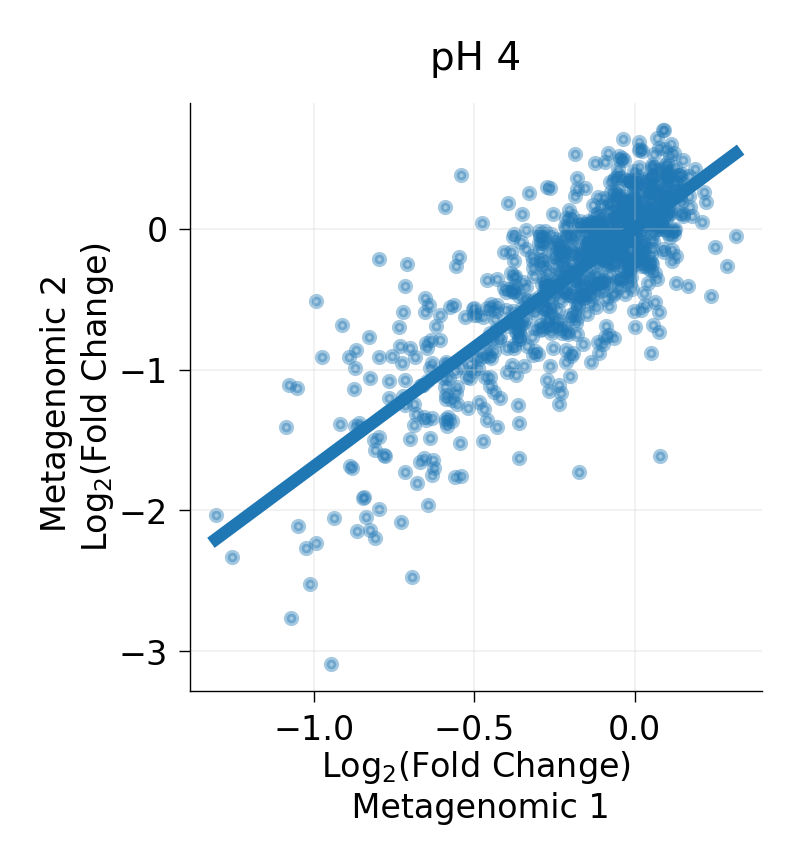

In [76]:
#Fit a line for aggregation at pH 4 for the overlap proteins measured in meta1 and meta2
sns.lmplot(x="meta1_log2fc_4", y="meta2_log2fc_4", data=pH4_overlap, ci=None,    height=2,  aspect=1, scatter_kws = {'s':3, 'alpha':0.4})

plt.title("pH 4")

plt.ylabel( 'Metagenomic 2 \n'+ r'$\mathrm{Log}_{2}$(Fold Change)' ,fontsize = 6)
plt.xlabel(r'$\mathrm{Log}_{2}$(Fold Change)' +'\n Metagenomic 1', fontsize = 6)

#Get slope and intercept
m, b = np.polyfit(pH4_overlap["meta1_log2fc_4"], pH4_overlap["meta2_log2fc_4"], 1)
print(f"y = {m:.4f}x + {b:.4f}")

#Use the slope and intercept to correct meta 1 aggregation measures
pH4_overlap["meta1_log2fc_4_corrected"] = pH4_overlap["meta1_log2fc_4"]*m + b

In [ ]:
#Calculate Mean Absolute Difference between corrected and not corrected values
mad_4_corr = np.mean(np.abs(pH4_overlap["meta1_log2fc_4_corrected"] - pH4_overlap["meta2_log2fc_4"]))
mad_4 = np.mean(np.abs(pH4_overlap["meta1_log2fc_4"] - pH4_overlap["meta2_log2fc_4"]))

#Calculate the bootstrapped correlations and slopes between meta 1 and meta2 values
boot_4 = bootstrap_corr_slope(pH4_overlap["meta1_log2fc_4"],pH4_overlap["meta2_log2fc_4"])
boot_4_corr = bootstrap_corr_slope(pH4_overlap["meta1_log2fc_4_corrected"],pH4_overlap["meta2_log2fc_4"])


y = 1.6939x + 0.0047


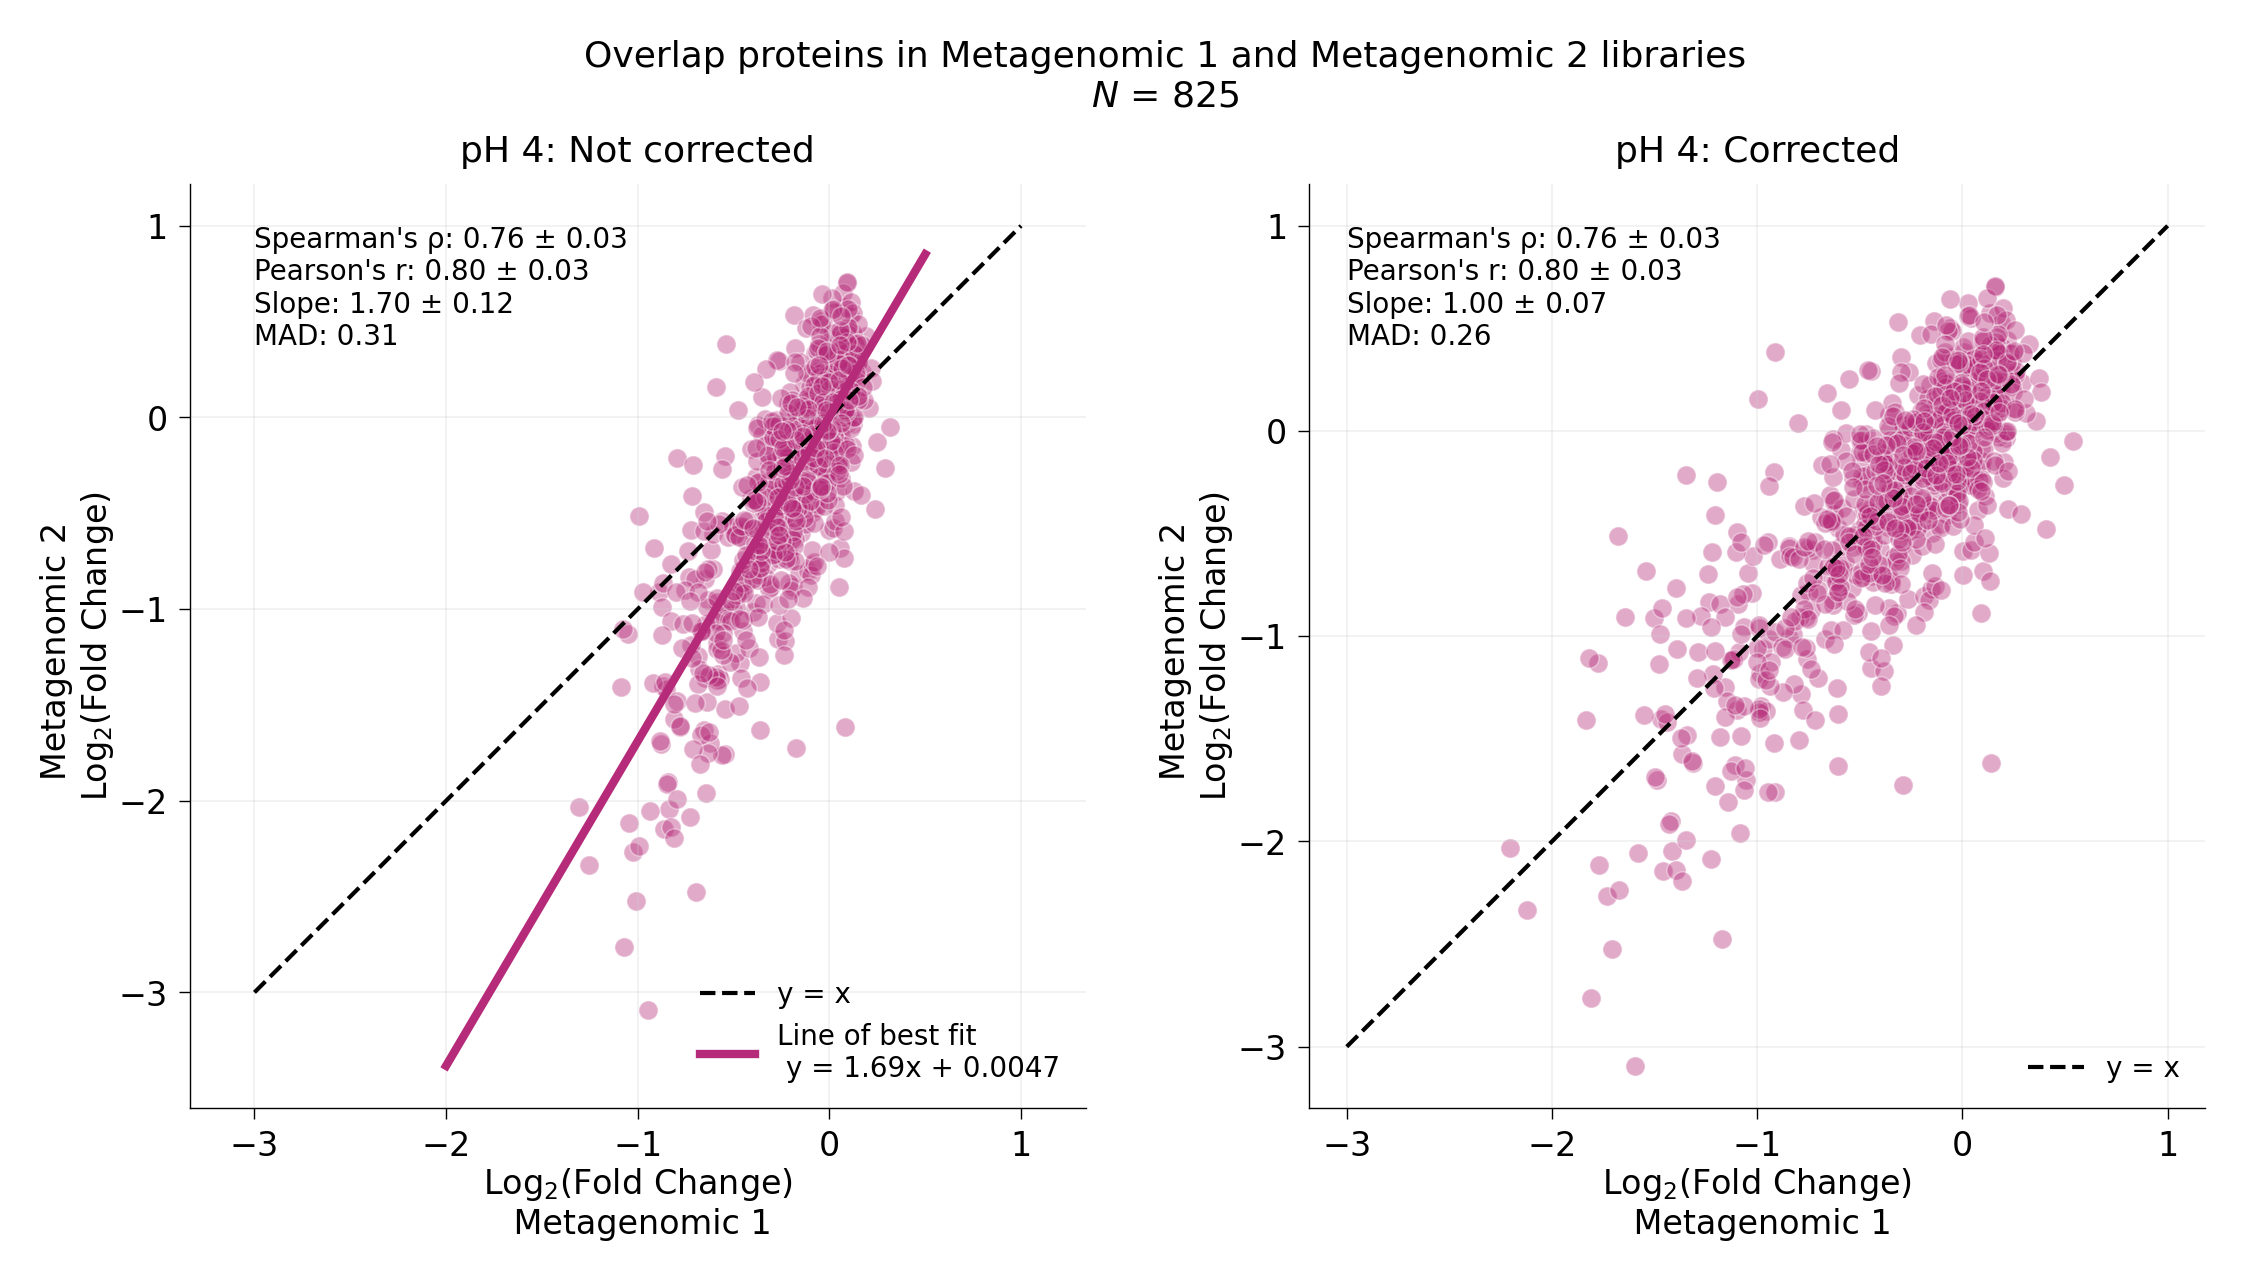

In [ ]:
#Plot the comparison between meta 1 and meta 2 values for the overlap proteins when not corrected (left) and corrected (right)
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6.5,3))
color_pH = "#b62b79"

sns.scatterplot(data=pH4_overlap, x="meta1_log2fc_4", y="meta2_log2fc_4", ax = axes [0],color = color_pH, alpha = 0.4,s=12)
axes[0].plot([-3, 1], [-3, 1], linestyle = "--", color = "black", linewidth = 0.75, label = "y = x")

sns.scatterplot(data=pH4_overlap, x="meta1_log2fc_4_corrected", y="meta2_log2fc_4", ax = axes [1], color = color_pH, alpha = 0.4,s=12)
axes[1].plot([-3, 1], [-3, 1], linestyle = "--", color = "black", linewidth = 0.75, label = "y = x")

plt.suptitle("Overlap proteins in Metagenomic 1 and Metagenomic 2 libraries\n" r"$\mathit{N}$" " = 825", ha="center",  fontsize = 6.5, va="top",  y=1)
axes[0].set_title("pH 4: Not corrected",fontsize = 6.5,pad =4)
axes[1].set_title("pH 4: Corrected",fontsize = 6.5,pad =4)
axes[0].set_xlabel(r'$\mathrm{Log}_{2}$(Fold Change)' +'\n Metagenomic 1', fontsize = 6)
axes[0].set_ylabel( 'Metagenomic 2 \n'+ r'$\mathrm{Log}_{2}$(Fold Change)' ,fontsize = 6)
axes[1].set_xlabel(r'$\mathrm{Log}_{2}$(Fold Change)' +'\n Metagenomic 1', fontsize = 6)
axes[1].set_ylabel( 'Metagenomic 2 \n'+ r'$\mathrm{Log}_{2}$(Fold Change)' ,fontsize = 6)

print(f"y = {m:.4f}x + {b:.4f}")

x = np.linspace(-2, 0.5, 200)
y = m * x + b

# Plot the line of best fit 
axes[0].plot(x, y, color=color_pH, label = f"Line of best fit\n y = {m:.2f}x + {b:.4f}")

axes[0].text(-3, 1,
    "Spearman's ρ: " f'{format_ci(*boot_4["spearman"])}\n'
    "Pearson's r: " f'{format_ci(*boot_4["pearson"])}\n'
    f'Slope: {format_ci(*boot_4["slope"])}\n'
             f'MAD: {mad_4:.2f}',
    fontsize=5, ha='left', va='top'
)

axes[1].text(-3, 1,
    "Spearman's ρ: " f'{format_ci(*boot_4_corr["spearman"])}\n'
    "Pearson's r: " f'{format_ci(*boot_4_corr["pearson"])}\n'
    f'Slope: {format_ci(*boot_4_corr["slope"])}\n'
    f'MAD: {mad_4_corr:.2f}',
    fontsize=5, ha='left', va='top'
)
for ax in axes:
     ax.set_aspect('equal', 'datalim')
axes[0].set_yticks([-3,-2,-1,1,0])
axes[1].set_yticks([-3,-2,-1,1,0])
axes[0].legend(frameon = False,loc="lower right")        
axes[1].legend(frameon = False,loc="lower right")  
plt.subplots_adjust(wspace=0.25)

initialize_notebook()


In [ ]:
#Correct the pH values for all proteins based on the overlap proteins
meta1["log2_fold_change_4_corrected"] = meta1["log2_avg_norm_total_4_div_avg_norm_total_7_center_peak_0_not_clip"]*m + b